In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import RepeatedKFold,cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector



In [49]:
data=pd.read_csv('cars.csv',delimiter=';')
data=data[1:]

#data['MPG'].unique()
data=data[(data['Horsepower']!='0') & (data['MPG']!='0')]

selcols = data.columns[1:][:-2]

for col in selcols:
    data[col] = data[col].astype('float')
data.info()


data= data.drop(['Car','Cylinders'],axis=1)
print (data.shape)

Y=data['MPG']

X= data.drop(['MPG'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=22)





<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 406
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car           392 non-null    object 
 1   MPG           392 non-null    float64
 2   Cylinders     392 non-null    float64
 3   Displacement  392 non-null    float64
 4   Horsepower    392 non-null    float64
 5   Weight        392 non-null    float64
 6   Acceleration  392 non-null    float64
 7   Model         392 non-null    object 
 8   Origin        392 non-null    object 
dtypes: float64(6), object(3)
memory usage: 30.6+ KB
(392, 7)


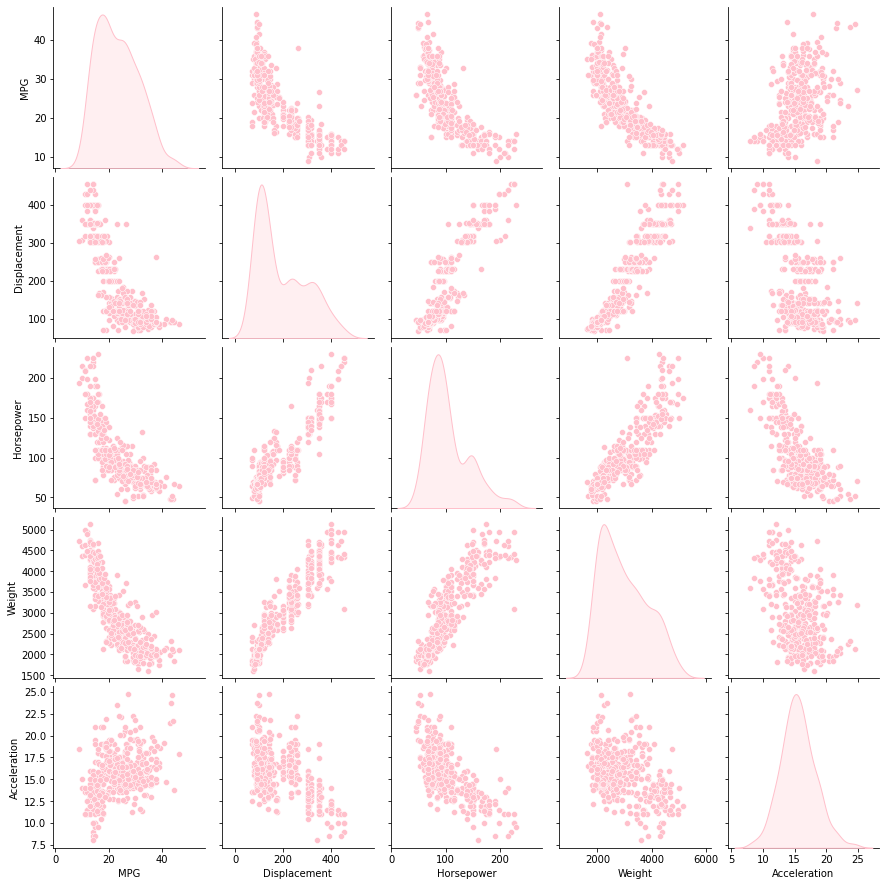

In [42]:
sns.pairplot(data, plot_kws={'color':'pink'}, diag_kws={'color':'pink'}, diag_kind = 'kde')

# It is aparent that there is strong collinerity in the dataset. We are choosing 3 models for comparison- Ridge Regression, Gradient Boosted Regressor and Random Forest.

# Preprocessing : categorical features are onehotencoded. Numerical  features are scaled. The target variable is lognormal since the distribution is skewed. 



In [18]:
# Preprocessing data to mumrical and categorical column



numerical_columns = ['Displacement', 'Horsepower', 'Weight', 'Acceleration']
categorical_columns = ['Origin', 'Model']


categorical_preprocessor = OneHotEncoder(drop = "if_binary")
numerical_preprocessor = StandardScaler()


from sklearn.compose import ColumnTransformer, TransformedTargetRegressor


preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])


prep2 =  ColumnTransformer([('one-hot-encoder', categorical_preprocessor, categorical_columns)])



# Ridge regression

In [50]:
# make Ridge , log nomal on y, as mpg distribution is skewed

pipe = Pipeline([('prepo',preprocessor),('model',TransformedTargetRegressor(regressor= Ridge(), func=np.log10, inverse_func=sp.special.exp10))])




cv =  RepeatedKFold(n_splits=5, n_repeats=3, random_state=1) #KFold(n_splits=5)

grid = dict()
grid = [{'model__regressor__alpha': np.arange(0.01,0.5,0.1)}]


# define the grid search procedure
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, cv=cv, scoring='neg_mean_squared_error')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)


# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))












Best: -7.503239 using {'model__regressor__alpha': 0.11}


In [51]:
# prediction with ridge

y_pred1 = grid_search.predict(X_test)


from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(y_pred1,y_test)

print (mse1)

9.67394595332963


# Gradient Boost Regressor

In [52]:
# train GBR


pipe = Pipeline([('prepo',preprocessor),('model',GradientBoostingRegressor())])
    
    
# define the grid of values to search
grid = dict()
grid['model__n_estimators'] = [10, 50, 100, 200, 300,  500]
grid['model__learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['model__subsample'] = [0.5, 0.7, 1.0]
grid['model__max_depth'] = [3, 7, 9]




# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, cv=cv, scoring='neg_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: -7.885097 using {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.5}


In [53]:

# prediction with GBR

y_pred2 = grid_search.predict(X_test)


from sklearn.metrics import mean_squared_error
mse2 = mean_squared_error(y_pred2,y_test)

print (mse2)


9.984004439724385


# Random Forest 
(pay more attention to hyperparameters?)

In [54]:
pipe = Pipeline([('prepo',preprocessor),('model',RandomForestRegressor(random_state = 20))])


# define the grid of values to search
grid = dict()
grid['model__n_estimators'] = [10, 50, 100, 200, 300,  500]
grid["model__max_features"] = ["auto", "sqrt", "log2"]
grid["model__min_samples_split"] = [2,4,8]
grid['model__max_depth'] = [3, 7, 9, 11, 13]




# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, cv=cv, scoring='neg_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


    

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value

/home/pragati/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best: -9.065365 using {'model__max_depth': 13, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 300}


In [55]:
# predict with RF

y_pred3 = grid_search.predict(X_test)


from sklearn.metrics import mean_squared_error
mse3 = mean_squared_error(y_pred3,y_test)

print (mse3)

10.378323585065075


{'Ridge': 3.1102967629037637, 'GBR': 3.1597475278452842, 'RF': 3.22154056082879}


,Algorithms,RMSE
0,Ridge,3.110297
1,GBR,3.159748
2,RF,3.221541


<AxesSubplot:xlabel='Algorithms', ylabel='RMSE'>

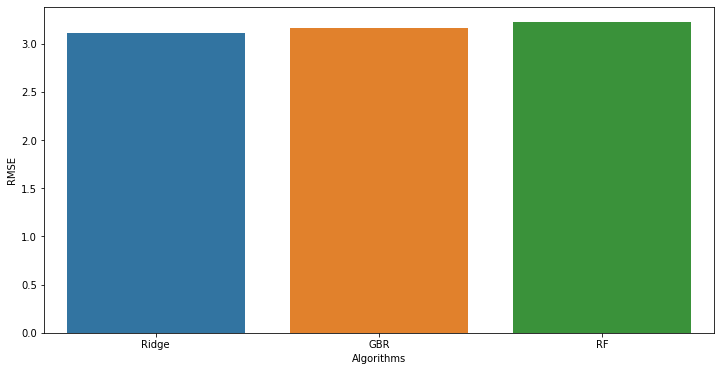

In [56]:
rmse = {'Ridge':np.sqrt(mse1), 'GBR': np.sqrt(mse2), 'RF': np.sqrt(mse3)}

fig, (ax1) = plt.subplots(ncols=1, sharey=True,figsize=(12,6))
new_df=pd.DataFrame(list(rmse.items()),columns=['Algorithms','RMSE'])
display(new_df)
sns.barplot(x="Algorithms", y="RMSE", data=new_df,ax=ax1)